## Image Classification

### Decreasing the Overfitting problem using Dropout technique

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process



Reference
https://www.tensorflow.org/tutorials/images/classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Download and Investigate the data

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 12s 0us/step


'pathlib.Path' is a class in the Python standard library's pathlib module that represents a file or directory path in a platform-independent way. It provides a convenient and expressive way to interact with the file system.

Path objects have various methods and properties to perform operations on files and directories. Here are some commonly used ones:

* exists(): Returns True if the file or directory exists.
* is_file(): Returns True if the path refers to a file.
* is_dir(): Returns True if the path refers to a directory.
* name: Returns the name of the file or directory.
* parent: Returns the parent directory of the path.
* resolve(): Resolves the absolute path of the path object.
* joinpath(): Joins the given path segments with the current path.
* mkdir(): Creates a new directory at the given path.
* unlink(): Deletes the file at the given path.
* rename(): Renames or moves the file or directory.

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


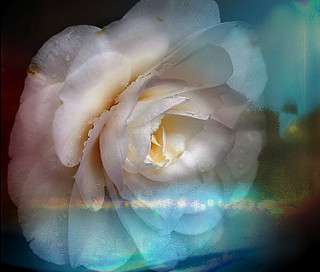

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

### Load data using a Keras utility

Load these images off disk using the helpful "**tf.keras.utils.image_dataset_from_directory**" utility. This will take you from a directory of images on disk to a tf.data.Dataset

In [6]:
batch_size = 32
img_height = 180
img_width = 180
SEED=42

IMG_SIZE = (img_height, img_width)

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=SEED,
                                                       image_size=IMG_SIZE,
                                                       batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Configure the Performance

* "Dataset.cache" keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* "Dataset.prefetch" overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)  #  The argument 1000 specifies the buffer size for shuffling, 
# indicating the number of elements from the dataset that will be loaded into memory for random selection.
# This line prefetches the training dataset, which means that the data is loaded asynchronously in the 
# background while the model is training on the current batch.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

In [27]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Create Conv Model

In [28]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

### Train the Model

In [31]:
epochs=10

model_history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
92/92 [==============================] - 4s 23ms/step - loss: 1.2615 - accuracy: 0.4659 - val_loss: 1.0906 - val_accuracy: 0.5627
Epoch 2/10
92/92 [==============================] - 2s 21ms/step - loss: 0.9459 - accuracy: 0.6396 - val_loss: 1.0092 - val_accuracy: 0.6131
Epoch 3/10
92/92 [==============================] - 2s 21ms/step - loss: 0.7614 - accuracy: 0.7105 - val_loss: 0.9812 - val_accuracy: 0.6431
Epoch 4/10
92/92 [==============================] - 2s 24ms/step - loss: 0.5714 - accuracy: 0.7936 - val_loss: 1.0337 - val_accuracy: 0.6540
Epoch 5/10
92/92 [==============================] - 2s 21ms/step - loss: 0.3472 - accuracy: 0.8856 - val_loss: 1.1690 - val_accuracy: 0.6335
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1793 - accuracy: 0.9458 - val_loss: 1.3059 - val_accuracy: 0.6499
Epoch 7/10
92/92 [==============================] - 2s 24ms/step - loss: 0.1082 - accuracy: 0.9642 - val_loss: 1.7341 - val_accuracy: 0.6144
Epoch 8/10
92

### Visualizing the training Results

In [32]:
def visualize_train_val_scores(model_history):
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']
  
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  
  epochs_range = range(epochs)
  
  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

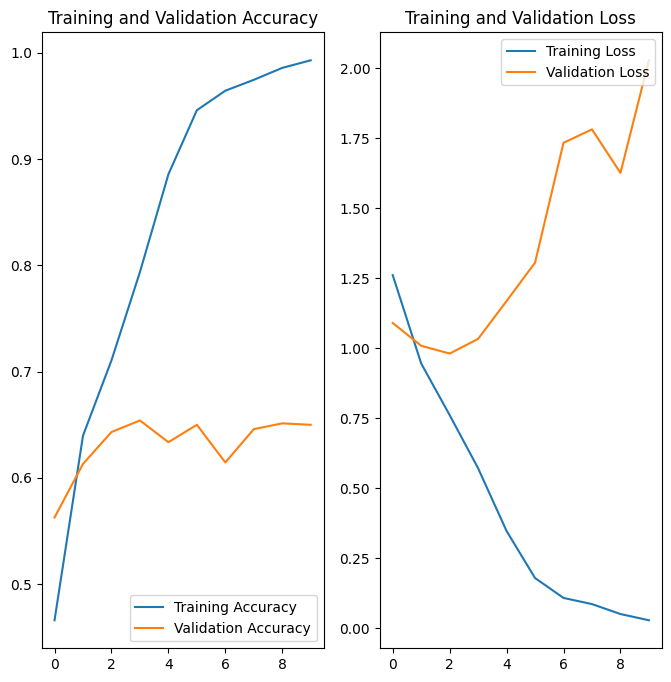

In [33]:
visualize_train_val_scores(model_history)

### Using Dropout Technique to overcome the Overfitting problem

A form of regularization useful in training neural networks. Dropout regularization removes a random selection of a fixed number of the units in a network layer for a single gradient step. The more units dropped out, the stronger the regularization.

In [34]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),   # Adding Dropout layer before flatten the data
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compile and Train the model again

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

In [37]:
model_history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 4s 30ms/step - loss: 1.4233 - accuracy: 0.3896 - val_loss: 1.1118 - val_accuracy: 0.5354
Epoch 2/10
92/92 [==============================] - 3s 29ms/step - loss: 1.0750 - accuracy: 0.5647 - val_loss: 1.0057 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 3s 29ms/step - loss: 0.9099 - accuracy: 0.6529 - val_loss: 0.9739 - val_accuracy: 0.6267
Epoch 4/10
92/92 [==============================] - 3s 32ms/step - loss: 0.7521 - accuracy: 0.7241 - val_loss: 0.9419 - val_accuracy: 0.6444
Epoch 5/10
92/92 [==============================] - 2s 27ms/step - loss: 0.5619 - accuracy: 0.7990 - val_loss: 1.0112 - val_accuracy: 0.6444
Epoch 6/10
92/92 [==============================] - 3s 29ms/step - loss: 0.3753 - accuracy: 0.8726 - val_loss: 1.0886 - val_accuracy: 0.6431
Epoch 7/10
92/92 [==============================] - 3s 28ms/step - loss: 0.2313 - accuracy: 0.9264 - val_loss: 1.3488 - val_accuracy: 0.6322
Epoch 8/10
92

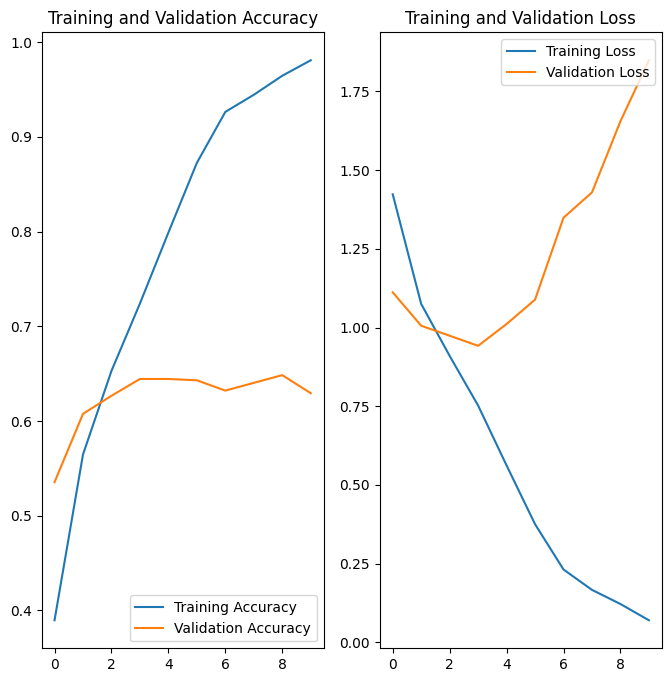

In [38]:
visualize_train_val_scores(model_history)

<Axes: >

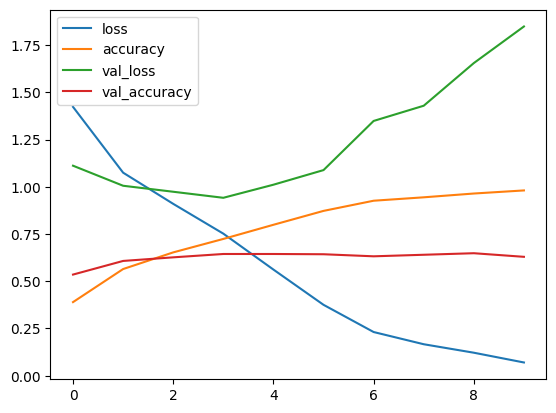

In [40]:
import pandas as pd

pd.DataFrame(model_history.history).plot()

### Prediction

In [41]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

117948/117948 [==============================] - 0s 3us/step


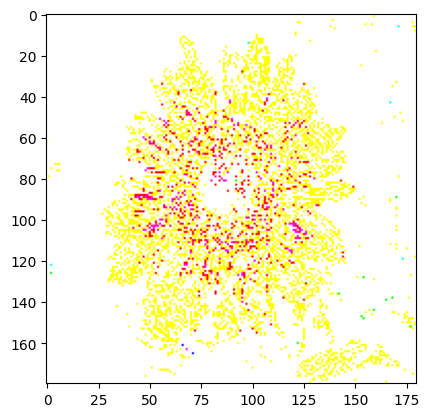

In [51]:
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
plt.imshow(img_array)
img_array = tf.expand_dims(img_array, 0) # Create a batch   [1, img_height, img_width, 3]

In [44]:
img_array.shape

TensorShape([1, 180, 180, 3])

In [45]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

1/1 [==============================] - 0s 202ms/step


In [46]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 87.51 percent confidence.
